In [8]:
# CSC396 - Intro to Deep Learning w/ NLP
# Claire Lynch & Jose Santiago Campa Morales
# Final Project
# Hate Speech and Offensive Language Classifier

import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# versions
print(f'torch version: {torch.__version__}')
print(f'transformers version: {transformers.__version__}')
print(f'transformers file: {transformers.__file__}')
#print(inspect.signature(TrainingArguments))

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
torch version: 2.5.1+cu121
transformers version: 4.56.2
transformers file: C:\Users\jscm1\anaconda3\envs\csc396-gpu\lib\site-packages\transformers\__init__.py
random seed: 1234


In [9]:
# 1. Work on dataset
# Load dataset
file_path = "data/labeled_data.csv"
train_df = pd.read_csv(file_path)

train_df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [10]:
# Only use tweet and class columns
# Original: # [count, hate_speech, offensive_language, neither, class, tweet]
train_df = train_df[['class', 'tweet']].copy()

# Map classes to labels
label_map = {
    0: "hate_speech",
    1: "offensive_language",
    2: "neither"
}

train_df['label'] = train_df['class'].map(label_map)
train_df = train_df[['class', 'label', 'tweet']]

train_df

,class,label,tweet
0,2,neither,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,offensive_language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,offensive_language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,offensive_language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,offensive_language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...
24778,1,offensive_language,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,neither,"you've gone and broke the wrong heart baby, an..."
24780,1,offensive_language,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,offensive_language,youu got wild bitches tellin you lies


In [11]:
# Samples
print("\nSample tweets:")
print(train_df.sample(10))


Sample tweets:
       class               label  \
9236       1  offensive_language   
1022       1  offensive_language   
2785       2             neither   
20895      1  offensive_language   
12505      1  offensive_language   
2301       2             neither   
608        1  offensive_language   
15019      1  offensive_language   
16696      1  offensive_language   
1209       2             neither   

                                                   tweet  
9236   Fuck all y'all hoes &#128567; gang shit &#1281...  
1022   &#128530;RT @SedSince81: niggers RT @VonshayeB...  
2785   @Carxlito PS3 and case is still in the trash c...  
20895                 Smellin good, bitches wanna hug me  
12505                                   Lmao this bitch.  
2301   @0xabad1dea Hard to QA? Time is also a pain to...  
608    "You can take someone out of the ghetto, but y...  
15019  RT @DomBeets: I wish someone would make a song...  
16696  RT @NorrisDaGod: I ain't never had a basic bit...

In [12]:
# Basic Stats
print("\nLabel distribution:")
print(train_df['label'].value_counts())


Label distribution:
label
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


C:\Users\jscm1\AppData\Local\Temp\ipykernel_54384\2267843281.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_df['label']).plot.bar()


<Axes: xlabel='label'>

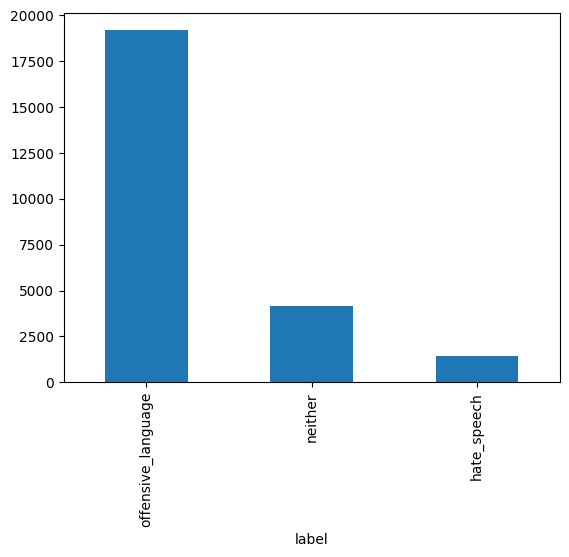

In [13]:
pd.value_counts(train_df['label']).plot.bar()

In [14]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['tweet'].tolist(),
    train_df['class'].tolist(),
    test_size=0.2,
    random_state=16
)

In [20]:
# Transformer from Hugging Face
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertModel
from sklearn.metrics import accuracy_score, classification_report

In [21]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels              # 0=hate, 1=offensive, 2=neither
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [22]:
# BERT Classifier
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes=3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output           # CLS embedding
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

    # Training loop
    def train_loop(model, data_loader, optimizer, scheduler, device):
        model.train()
        total_loss = 0

        for batch in data_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            total_loss += loss.item()

        return total_loss / len(data_loader)

    # Evaluation loop
    def evaluate(model, data_loader, device):
        model.eval()
        predictions = []
        actual_labels = []

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                _, preds = torch.max(outputs, dim=1)

                predictions.extend(preds.cpu().tolist())
                actual_labels.extend(labels.cpu().tolist())

        acc = accuracy_score(actual_labels, predictions)
        report = classification_report(
            actual_labels,
            predictions,
            target_names=["hate_speech", "offensive_language", "neither"]
        )
        
        return acc, report

    # Predict on a single text
    def predict(text, model, tokenizer, device, max_length=128):
        model.eval()

        encoding = tokenizer(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            _, pred = torch.max(outputs, dim=1)

        label_map = {
            0: "hate_speech",
            1: "offensive_language",
            2: "neither"
        }

        return label_map[pred.item()]

In [23]:
bert_model_name = 'bert-base-uncased'
num_classes = 3
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [25]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\jscm1\anaconda3\envs\csc396-gpu\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jscm1\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [29]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*warmup_steps),
    num_training_steps=total_steps
)

In [30]:
for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # TRAINING
    model.train()
    total_train_loss = 0

    progress_bar = tqdm(train_dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_dataloader)

    # VALIDATION
    model.eval()
    all_preds = []
    all_labels = []

    val_bar = tqdm(val_dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_acc = accuracy_score(all_labels, all_preds)

    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(classification_report(
        all_labels, all_preds,
        target_names=["hate_speech", "offensive_language", "neither"]
    ))



===== Epoch 1/4 =====


Training:   0%|          | 0/1240 [00:00<?, ?it/s]

Validating:   0%|          | 0/310 [00:00<?, ?it/s]

Train Loss: 0.2995
Val Accuracy: 0.9135
                    precision    recall  f1-score   support

       hate_speech       0.56      0.10      0.17       275
offensive_language       0.92      0.98      0.95      3854
           neither       0.89      0.88      0.89       828

          accuracy                           0.91      4957
         macro avg       0.79      0.65      0.67      4957
      weighted avg       0.90      0.91      0.90      4957


===== Epoch 2/4 =====


Training:   0%|          | 0/1240 [00:00<?, ?it/s]

Validating:   0%|          | 0/310 [00:00<?, ?it/s]

Train Loss: 0.2014
Val Accuracy: 0.9179
                    precision    recall  f1-score   support

       hate_speech       0.69      0.16      0.26       275
offensive_language       0.93      0.98      0.95      3854
           neither       0.88      0.90      0.89       828

          accuracy                           0.92      4957
         macro avg       0.83      0.68      0.70      4957
      weighted avg       0.91      0.92      0.90      4957


===== Epoch 3/4 =====


Training:   0%|          | 0/1240 [00:00<?, ?it/s]

Validating:   0%|          | 0/310 [00:00<?, ?it/s]

Train Loss: 0.1444
Val Accuracy: 0.9078
                    precision    recall  f1-score   support

       hate_speech       0.48      0.39      0.43       275
offensive_language       0.94      0.95      0.95      3854
           neither       0.88      0.87      0.88       828

          accuracy                           0.91      4957
         macro avg       0.77      0.74      0.75      4957
      weighted avg       0.90      0.91      0.91      4957


===== Epoch 4/4 =====


Training:   0%|          | 0/1240 [00:00<?, ?it/s]

Validating:   0%|          | 0/310 [00:00<?, ?it/s]

Train Loss: 0.0960
Val Accuracy: 0.9118
                    precision    recall  f1-score   support

       hate_speech       0.47      0.43      0.45       275
offensive_language       0.95      0.95      0.95      3854
           neither       0.89      0.90      0.89       828

          accuracy                           0.91      4957
         macro avg       0.77      0.76      0.76      4957
      weighted avg       0.91      0.91      0.91      4957



In [ ]:
torch.save(model.state_dict(), "bert_hatespeech_model.pt")